# Analyzing news headlines with spaCy

For many machine learning tasks, we must collect specific training data, labeling the data, and invest substantial time in developing a custom model for our purpose. However, there are some tasks that are sufficiently universal that pre-trained models can provide at least a proof of concept, and perhaps a production solution.

One area where this is common is natural language processing. Language use varies between sources&mdash;a quarterly financial report will differ substantially from comic book dialogue&mdash;but most of the essential rules of a given language (we'll stick with English for this notebook) do not change between sources. This means that language models trained for certain tasks are widely applicable. Even if a better result would be possible with a model that is fine tuned to a dataset, the feasibility of a product can often be evaluated with pre-trained solutions.

The [spaCy](https://spacy.io/) library from [explosion.ai](https://explosion.ai/) is designed to provide production ready solutions to NLP tasks. The emphasis is on exposing mature capabilities for real-world use, as opposed to providing a comprehensive list of subtly-different models.

In this notebook, we'll use spaCy for named entity recognition (NER). In NER, the task is to identify so-called named entities in a body of text, and classify their entity type. By default, spaCy recognises [18 distinct categories](https://spacy.io/api/annotation#named-entities) of named entity, encompassing people, geopolitical entities, dates, works of arts, monetary figures and more.

Our use case is to investigate the appearance of organisations in Reuters news headlines. Tracking organisational appearances is interesting in itself, and could form part of a pipeline for competitive analysis, national statistical reporting or sector-specific analysis (for instance, in banking).

## Setup notebook dependencies

First we must install a couple of dependencies, import them, and enable inline plotting.

In [1]:
%%capture
# ^ hiding large cell output. disable for logs.
!pip3 install spacy pandas numpy matplotlib seaborn
!python3 -m spacy download en_core_web_sm

In [2]:
import spacy
import en_core_web_sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


Bad key backend.qt4 in file /etc/matplotlib/matplotlibrc, line 43 ('backend.qt4 : PyQt4        # PyQt4 | PySide')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
%matplotlib inline

## Load data

We'l use a public domain dataset of Reuters news headlines spanning March 2018 through July 2020 (from [Kaggle](https://www.kaggle.com/notlucasp/financial-news-headlines)). The data contains more than 32,000 headlines, with associated dates, and a short article description (which we ignore). 

In [4]:
reuters_headline_df = pd.read_csv('reuters_headlines.csv', parse_dates=[1])
reuters_headline_df.head()

,Headlines,Time,Description
0,TikTok considers London and other locations fo...,2020-07-18,TikTok has been in discussions with the UK gov...
1,Disney cuts ad spending on Facebook amid growi...,2020-07-18,Walt Disney has become the latest company to ...
2,Trail of missing Wirecard executive leads to B...,2020-07-18,Former Wirecard chief operating officer Jan M...
3,Twitter says attackers downloaded data from up...,2020-07-18,Twitter Inc said on Saturday that hackers were...
4,U.S. Republicans seek liability protections as...,2020-07-17,A battle in the U.S. Congress over a new coron...


## Extract entities with spaCy

To detect entities and their type (spaCy refers to this as their _label_) in text, we must use a statistical model. Here, we use spaCy's `en_core_web_sm` model. This is an English language model trained on web data, and is lightweight at 11MB. Larger versions of this model, and their performance characteristics, can be found in the [spaCy docs](https://spacy.io/models/en). spaCy also provides support for [non-English languages](https://spacy.io/usage/models#languages). Under the hood, this is a convolutional neural network, but since it is already trained and we're using it as is, we can consider it a simple function with known statistical performance.

In [5]:
nlp = en_core_web_sm.load()

To extract entities from a single document, we simply calling `nlp` on the document: `nlp("Here is some text")`. When we do so, the text is tokenized, and several components of an NLP pipeline are run on the tokens: they're tagged for part-of-speech labels (verb, noun, etc.) and assigned dependency labels with a parser.

To extract entities from many headlines, it is considerably more performant to use spaCy's built in pipeline abstraction than to `apply` the operation with pandas. Since we care only about extracting named entities from the text, we can also disable the tagger and parser to avoid unnecessary work, improving speed.

In [6]:
entity_pipe = nlp.pipe(reuters_headline_df.Headlines, disable=['tagger', 'parser'])

In [7]:
# even with above performance considerations, this cell takes a minute
reuters_headline_df['Entities'] = [x.ents for x in entity_pipe]

For convenience, we'll construct a new DataFrame with only the columns we care about: date, headline, entity and entity label. Each row in the DataFrame is a single entity that has been extracted, so headlines containing multiple entities may appear multiple times.

In [8]:
entity_df = (
    reuters_headline_df
    .explode('Entities')
    [['Time', 'Headlines', 'Entities']]
    .rename(columns={'Entities': 'Entity', 'Headlines': 'Headline', 'Time': 'Date'})
    .dropna()
    .assign(
        Label = lambda df: df.Entity.apply(lambda x: x.label_),
        Entity = lambda df: df.Entity.apply(lambda x: x.text)
    )
    .reset_index(drop=True)
)

In [9]:
entity_df.head()

,Date,Headline,Entity,Label
0,2020-07-18,TikTok considers London and other locations fo...,London,GPE
1,2020-07-18,Disney cuts ad spending on Facebook amid growi...,Facebook,ORG
2,2020-07-18,Trail of missing Wirecard executive leads to B...,Wirecard,ORG
3,2020-07-18,Trail of missing Wirecard executive leads to B...,Belarus,GPE
4,2020-07-18,Trail of missing Wirecard executive leads to B...,Der Spiegel,PERSON


SpaCy provides a nice built in visualizer for extracted entities. Let's take a look at a couple of examples:

In [10]:
example_headlines = [
    "Disney cuts ad spending on Facebook amid growing boycott: WSJ",
    "TikTok considers London and other locations for headquarters",
    "KPMG hit by Hong Kong High Court in $400 million China Medical fraud",
    "Abu Dhabi's Etihad Airways restructures Airbus, Boeing jet orders",
    "Trail of missing Wirecard executive leads to Belarus, Der Spiegel reports"
]

for example in example_headlines:
    spacy.displacy.render(
        nlp(example),
        style="ent", jupyter=True
)

Clearly, this is not perfect. TikTok, Disney and WSJ were not identified as organisations. Der Spiegel is a German news organisation, not a person. Without a labeled test set, we cannot verify the robustness of the entity extraction on our particular data set. Metrics for the spaCy models are reported on the corresponding [model page](https://spacy.io/models/en). For `en_core_web_sm`, F-score, precision and recall all hang around 85%. It is an unavoidable reality of statistical models of text that they are imperfect.

Some of the failures we observed above do not occur if we use the larger `en_core_web_lg` language model. TikTok, Disney and WSJ are correctly identified as organisations. However, no model is perfect, and even the large model misidentifies Der Spiegel as a person.

> If you'd like to try out the larger model yourself, you can! You'll need to replace the model name in the cell where it is loaded above, and also download it and import it, like we do with en_core_web_sm in the first code cells of this notebook. Be warned, the large model is 746MB.

So then **why should we use a statistical model?** Why aren't we just extracting entities with regular expressions? Pattern matching will work for entities known ahead of time. For instance, if we only wanted to detect occurrences of "Facebook" or "Twitter", we could write rules to detect them. This approach is simple, and will match exactly the strings specified in the rules, regardless of context, which may be appropriate for some use cases.

In contrast, statistical NER techniques do not discriminate on the particular name of an entity, but rather on its usage. Consider the entity "White House" (identified as an organisation by spaCy). Pattern matching will not distinguish between the White House of [whitehouse.gov](https://www.whitehouse.gov/) and the White House in the phrase "How Many People Can Walter White House in His RV?" One could attempt to implement some heuristic rules to isolate the desired pattern. In practice, this is not always possible, and is extremely manual and error-prone; all the more so when many entities are sought.

In cases where seek to extract *entities* rather than words, especially when there is a likely naming conflict with words in common usage, we are often better served by a statistical approach.

## Most mentioned organisations

Having extracted entites from the Reuters headlines, we can now query them however we please. For instance, we could ask which organisations have been reported about most (by Reuters) in 2020:

In [11]:
(
    entity_df[
        (entity_df.Label == "ORG") &                # filter to organisation entities only
        (entity_df.Date.dt.year == 2020)            # filter to 2020 only
    ]
    .drop_duplicates()                              # count each headline once, even if org mentioned multiple times
    .groupby('Entity')
    .agg({'Headline': len})                         # count number of headlines in which each org appears
    .sort_values(by='Headline', ascending=False)    # order from most to least appearances
    .reset_index()
    .rename(columns={'Headline': '2020 Count'})
    .head(10)
)

,Entity,2020 Count
0,Fed,252
1,Boeing,210
2,EU,190
3,Amazon,144
4,Huawei,125
5,Apple,111
6,Airbus,109
7,Facebook,94
8,MAX,93
9,Lufthansa,93


The organisation appearing in the most headlines in 2020 is the "Fed"&mdash;the U.S. Federal Reserve Board. This is believable. Let's see some of those headlines:

In [12]:
entity_df[(entity_df.Date.dt.year == 2020) & (entity_df.Entity == "Fed")].sample(10).Headline.values

array(['Fed banks unanimously voted to keep discount rate unchanged - minutes',
       "Fed's money market move lifts Northern Trust fund above key threshold",
       'Fed officials signal rising caution on U.S. economic recovery amid virus spread',
       'U.S. economy faces hard slog back from pandemic, Fed chief says',
       'U.S. economy expands modestly but trade tensions weigh, Fed survey shows',
       'Fed\'s Bullard: "Material reassessment" is "big tent language"',
       "Fed's Harker says increase in coronavirus cases has direct economic impact",
       "Fed's Powell beats drum for more government aid to bolster economy",
       'Fed studying if new facility for small business loans might be opened to non-bank lenders',
       'Fund managers change tack as Fed reacts to virus'], dtype=object)

## Timeline of mentions for a named entity

Perhaps we are interested in tracking the appearance of an organisation in the news over time. We can view that with a simple line chart of mentions per day.

In [13]:
def occurence_plot(entity_name):
    ax = (
        entity_df[
            (entity_df.Label == "ORG") &         # select only entities of type organisation
            (entity_df.Entity == entity_name)    # select only a specific named entity
         ]
        .drop_duplicates()                       # count each headline once
        .groupby('Date')
        .agg(len)                                # count headlines containing the org on each date
        .plot(
            y='Entity',
            drawstyle='steps',
            legend=False,
            figsize=(8,2)
        )
    )
    ax.set_ylabel('Daily count')

For instance, we could look at mentions of aerospace company Boeing:

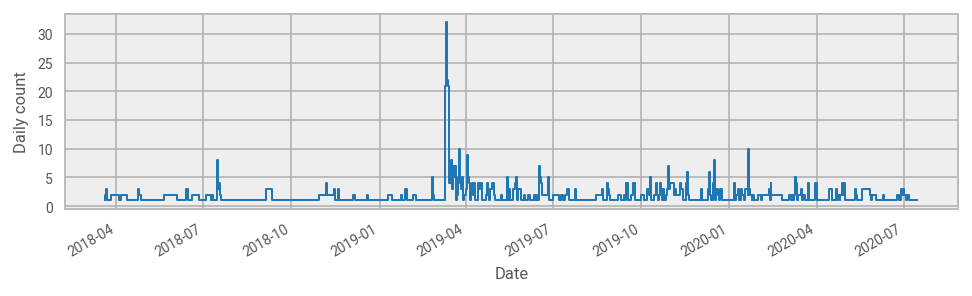

In [14]:
occurence_plot('Boeing')

There's a prominent spike in articles around March-April 2019. This corresponds to the [Boeing 737 MAX groundings](https://en.wikipedia.org/wiki/Boeing_737_MAX_groundings) following two unfortunate crashes. This also explains the presence of the "MAX" entity (misidentified as an organisation) in the top 10 mentioned organisations in 2020 (as testing continues).

## Organisation co-occurrence matrix

We may be interested in investigating which organisations are frequently mentioned together. Let's do so for 2020. We can transform our list of headlines and associated entities into a co-occurrence matrix.

In [15]:
# create a filtered dataframe for convenience
orgs_2020_df = (
    entity_df[
        (entity_df.Label == "ORG") &        # filter to organisation entities only
        (entity_df.Date.dt.year == 2020)    # filter to 2020 only
    ]
    [['Headline', 'Entity']]
    .drop_duplicates()                      # count each headline once, even if org mentioned multiple times
)

ct = pd.crosstab(orgs_2020_df.Headline, orgs_2020_df.Entity)
co_occurrence = ct.T.dot(ct)
np.fill_diagonal(co_occurrence.values, 0)   # remove self-co-occurrence !!! warning: in-place operation !!!

The result is a giant DataFrame where each organisational entity appears as both a row and column, with the value of each cell representing the count of times two organisations have co-occurred in a Reuters headline in 2020. We have removed the diagonal of the matrix, since all organisations co-occur with themselves every time they're mentioned.

For a given org, we can look up the other orgs it most frequently co-occurred with:

In [16]:
co_occurrence.loc['American Airlines'].sort_values(ascending=False).head()

Entity
Delta     2
Boeing    2
CNBC      1
MAX       1
United    1
Name: American Airlines, dtype: int64

Alternatively, we could check how often two orgs were mentioned together:

In [17]:
co_occurrence.loc['HSBC'].loc['Huawei']

2

Finally, we might be interested in seeing the full co-occurence matrix visualized. Some organisations never co-occurred with any other org in a Reuters headline in 2020, so we'll drop those rows and columns of zero.

In [18]:
no_zeros = co_occurrence.loc[(co_occurrence !=0 ).any(axis='rows'), (co_occurrence != 0).any(axis='columns')]

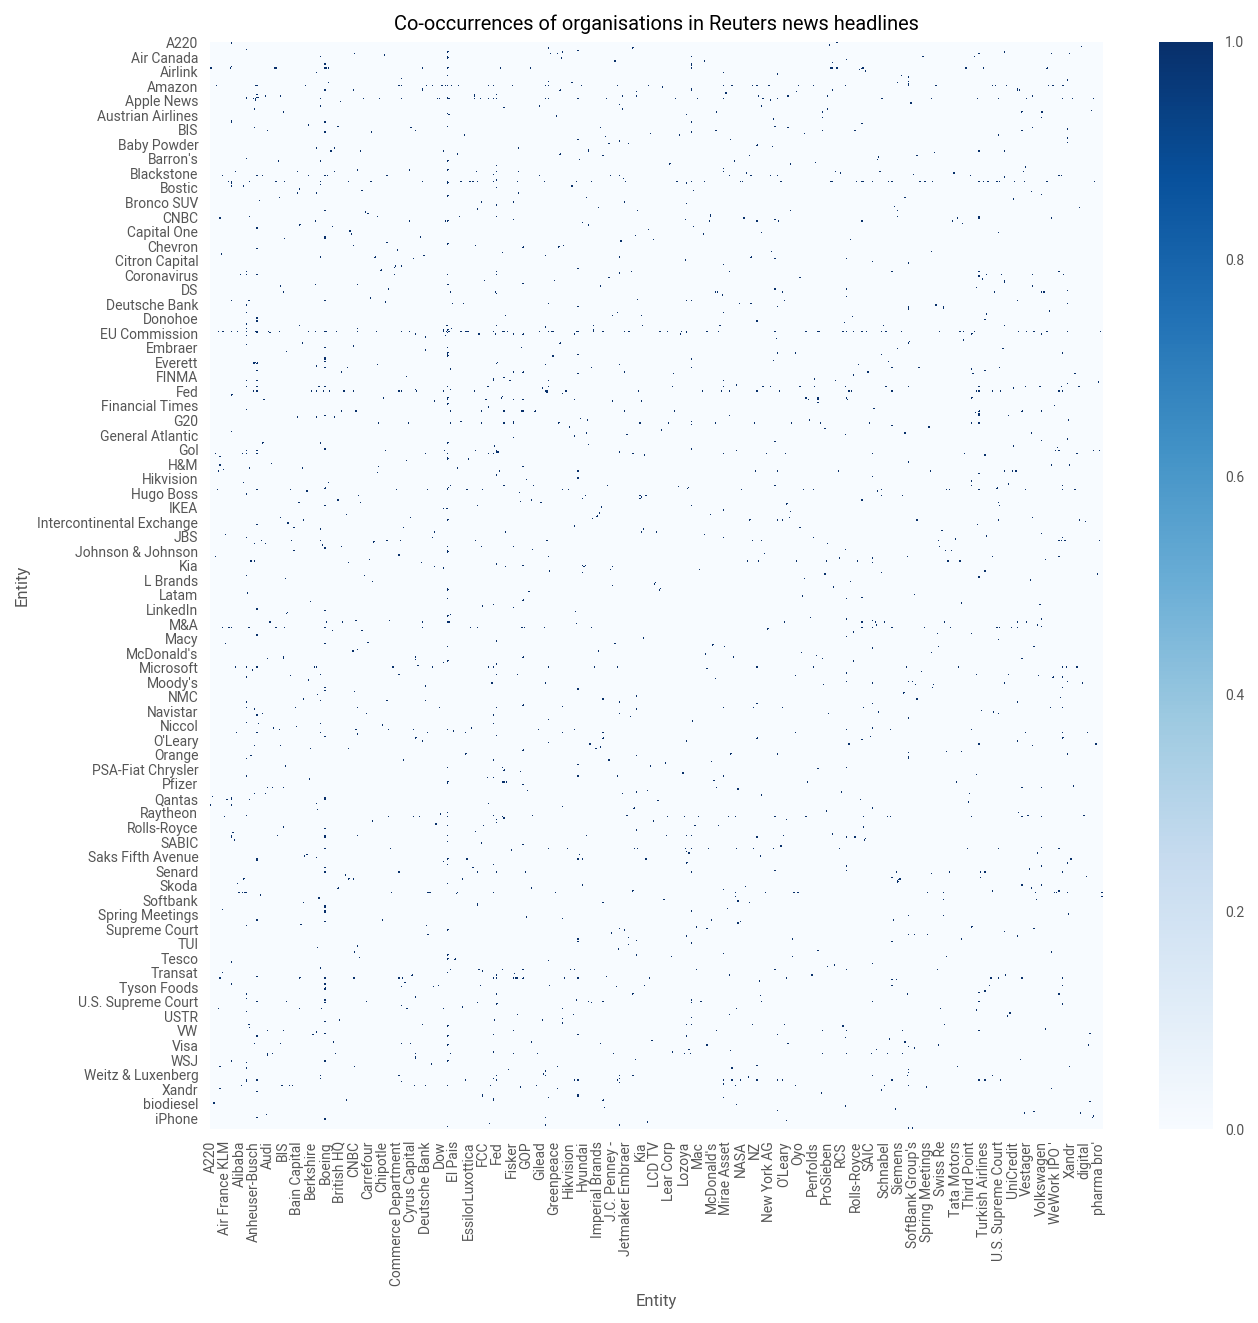

In [19]:
_, ax = plt.subplots(figsize=(10,10))
sns.heatmap(no_zeros > 0, cmap='Blues', ax=ax)
ax.set_title("Co-occurrences of organisations in Reuters news headlines");

We can't really indentify individual co-occurences in that chart, but we do learn that they are sparse. As expected, most organisations co-occur with only a handful of others.

## To spaCy and beyond

Hopefully, this notebook has inspired your own use cases for named entity recognition. NER is but one mature NLP capability, for which spaCy provides industrial strength tooling. Even without training our own model, we were able to prototype a couple of capabilities that might be the basis of tools for use by journalists, businesses, or national statistics organisations seeking to monitor company activity.

If we had been working with a more esoteric dataset, or wanted better entity recognition on our particular dataset, or desired different categories of entity, we could fine tune a model for the purpose. Doing so would require that we have data labeled with examples of the entities we want to extract. We could label that manually, employ a commercial labeling service, or use a purpose built tool like [prodi.gy](https://prodi.gy/) (from the makers of spaCy).

***If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices.  A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).***